In [24]:
import copy
import numpy as np
import cvxpy as cp
from gurobipy import Model, GRB
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [25]:
np.random.seed(0)

## SLPM

In [26]:
def solve_SLPM(num_goods, num_bidders, pi, A, b):
    
    # Initialize the model
    m = Model('SLPM')
    m.setParam('OutputFlag', 0)
    
    # Add variables xj for each bidder j
    # Assuming a continuous problem for the sake of accessing dual variables
    x = m.addVars(num_bidders, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")
    
    # Set the objective function
    m.setObjective(sum(pi[j] * x[j] for j in range(num_bidders)), GRB.MAXIMIZE)
    
    # Add constraints for each resource i and keep a reference to them
    constraints = []
    for i in range(num_goods):
        constraint = m.addConstr(sum(A[i][j] * x[j] for j in range(num_bidders)) <= b[i], name=f"resource_{i}")
        constraints.append(constraint)
    
    # Solve the model
    m.optimize()
    
    # Check the model status and output the solution and dual variables
    if m.status == GRB.OPTIMAL:
        optimal_value = m.objVal
        x_solution = m.getAttr('x', x)
        # print("Optimal allocation:", x_solution)
        
        # Retrieve and print the dual variables (shadow prices)
        dual_prices = {constraints[i].ConstrName: constraints[i].Pi for i in range(num_goods)}
        # print("Dual prices:", dual_prices)
        return np.array(list(dual_prices.values())), optimal_value
    else:
        print("No optimal solution found or the problem is not a continuous LP.")

In [27]:
# Define the parameters
m = 10  # number of goods
n = 10000  # number of bidders
b = np.array([100] * m)  # total available quantity of each good/resource

# Ground truth price vector p
p = np.random.rand(m)

# Function to generate bids
def generate_bids(num_bids, num_goods, p):
    A = np.random.choice([0, 1], size=(num_bids, num_goods))
    bids = np.dot(p, A.T) + np.random.normal(0, 0.2, num_bids)
    return A, bids

A_list = []
bids_list = []
for i in range(10):
    # p = np.random.rand(m)
    A, bids = generate_bids(n, m, p)
    A_list.append(A)
    bids_list.append(bids)

In [28]:
class SLPM_Agent(object):
    def __init__(self, m, n, b, A, bids):
        self.m = m
        self.n = n
        self.b = b
        self.A = A
        self.bids = bids
        self.cost = np.zeros(len(self.b))
        self.revenue_path = []

    def update_prices(self, k):
        self.prices, _ = solve_SLPM(self.m, k, self.bids[:k], self.A.T, self.b*k/self.n)
        return self.prices
        
    def simulate_revenue(self, k, T):
        '''
        update dual price with first k arrivals;
        simulate revenues starting from time k to time T;
        '''
        revenue = 0
        prices = self.update_prices(k)
        
        for i in range(k, T):
            thres = np.dot(self.A[i], prices)
            if self.bids[i] > thres and min(self.b - self.cost - self.A[i]) >= 0:
                self.cost += self.A[i]
                revenue += self.bids[i]
                self.revenue_path.append(self.bids[i])
            else:
                self.revenue_path.append(0)
        return revenue

    def rolling_simulate_revenue(self, k_list):
        revenue = 0
        for i in range(len(k_list) - 1):
            cur_revenue = self.simulate_revenue(k_list[i], k_list[i+1])
            revenue += cur_revenue
        revenue += self.simulate_revenue(k_list[-1], self.n)
        return revenue

    def simulate_offline(self):
        revenue = 0
        prices = self.update_prices(self.n)
        self.revenue_path = []
        
        for i in range(self.n):
            thres = np.dot(self.A[i], prices)
            if self.bids[i] > thres and min(self.b - self.cost - self.A[i]) >= 0:
                self.cost += self.A[i]
                revenue += self.bids[i]
                self.revenue_path.append(self.bids[i])
            else:
                self.revenue_path.append(0)
        return self.revenue_path

## SCPM

In [29]:
def solve_SCPM(m, n, pi, A, b, w=1, a_param=1, type='log'):
    # Define the decision variables
    x = cp.Variable(n, nonneg=True)  # x_j variables
    s = cp.Variable(m, nonneg=True)  # s_i variables
    
    # Define the utility function
    def utility_function(s, type='log'):
        if type == 'log':
            return (w/m) * cp.sum(cp.log(s))
        elif type == 'exp':
            return (w/m) * cp.sum(1 - cp.exp(-a_param * s))
        else:
            raise ValueError("Invalid utility function type")
    
    # Choose which utility function to use
    u = utility_function(s, type=type)
    # Define the constraints
    constraints = [cp.sum(A[i,:n] @ x) + s[i] <= b[i] for i in range(m)] + \
                  [x[j] <= 1 for j in range(n)]
    
    # Define the objective
    objective = cp.Maximize(cp.sum(cp.multiply(pi, x)) + u)
    
    # Define the problem and solve it
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    return np.array([constraint.dual_value for constraint in constraints[:m]])

In [30]:
class SCPM_Agent(object):
    def __init__(self, m, n, b, A, bids, w, a_param, type='log'):
        self.m = m
        self.n = n
        self.b = b
        self.A = A
        self.bids = bids
        self.cost = np.zeros(len(self.b))
        self.type = type
        self.revenue_path = []

        self.w = w
        self.a_param = a_param

    def update_prices(self, k):
        self.prices = np.array(solve_SCPM(self.m, k, self.bids[:k], self.A.T, self.b*k/self.n, self.w, self.a_param, self.type))
        return self.prices
        
    def simulate_revenue(self, k, T):
        '''
        update dual price with first k arrivals;
        simulate revenues starting from time k to time T;
        '''
        revenue = 0
        prices = self.update_prices(k)
        
        for i in range(k, T):
            thres = np.dot(self.A[i], prices)
            if self.bids[i] > thres and min(self.b - self.cost - self.A[i]) >= 0:
                self.cost += self.A[i]
                revenue += self.bids[i]
                self.revenue_path.append(self.bids[i])
            else:
                self.revenue_path.append(0)
        return revenue

    def rolling_simulate_revenue(self, k_list):
        revenue = 0
        for i in range(len(k_list) - 1):
            cur_revenue = self.simulate_revenue(k_list[i], k_list[i+1])
            revenue += cur_revenue
        revenue += self.simulate_revenue(k_list[-1], self.n)
        return revenue

    def simulate_offline(self):
        revenue = 0
        prices = self.update_prices(self.n)
        self.revenue_path = []
        
        for i in range(self.n):
            thres = np.dot(self.A[i], prices)
            if self.bids[i] > thres and min(self.b - self.cost - self.A[i]) >= 0:
                self.cost += self.A[i]
                revenue += self.bids[i]
                self.revenue_path.append(self.bids[i])
            else:
                self.revenue_path.append(0)
        return self.revenue_path

##  Action-history Dependent Learning Algorithm

In [31]:
class AHD_Agent(object):
    def __init__(self, m, n, b, A, bids):
        self.m = m
        self.n = n
        self.b = b
        self.A = A
        self.bids = bids
        self.cost = np.zeros(len(self.b))

    def update_prices(self, k):
        self.prices, _ = solve_SLPM(self.m, k, self.bids[:k], self.A.T, (self.b - self.cost)*k/(self.n-k))
        return self.prices

    def get_opt(self):
        _, self.opt = solve_SLPM(self.m, self.n, self.bids, self.A.T, self.b)
        
    def simulate_revenue(self, T):
        '''
        update dual price with first k arrivals;
        simulate revenues starting from time k to time T;
        '''
        revenue = 0
        k = 1
        prices = self.update_prices(k)
        self.get_opt()
        self.regret = []
        self.revenue = [0]
        for i in tqdm(range(1, T-1)):
            thres = np.dot(self.A[i], prices)
            if self.bids[i] > thres and min(self.b - self.cost - self.A[i]) >= 0:
                self.cost += self.A[i]
                revenue += self.bids[i]
            k += 1
            prices = self.update_prices(k)
            self.revenue.append(revenue)
            self.regret.append(revenue - self.opt*k/self.n)
            
        thres = np.dot(self.A[T-1], prices)
        if self.bids[T-1] > thres and min(self.b - self.cost - self.A[T-1]) >= 0:
            self.cost += self.A[T-1]
            revenue += self.bids[T-1]
        self.revenue.append(revenue)
        self.regret.append(revenue - self.opt)
        
        return self.revenue

## Online SGD Algorithm

In [32]:
class SGD_Agent(object):
    def __init__(self, m, n, b, A, bids):
        self.m = m
        self.n = n
        self.b = b
        self.A = A
        self.bids = bids
        self.cost = np.zeros(len(self.b))
        self.regret = []
        self.revenue = []

    def update_prices(self, k, x):
        self.prices = self.prices + (self.A[k]*x - self.b/self.n)/np.sqrt(k+1)
        return self.prices

    def get_opt(self):
        _, self.opt = solve_SLPM(self.m, self.n, self.bids, self.A.T, self.b)
        
    def simulate_revenue(self, T):
        '''
        update dual price with first k arrivals;
        simulate revenues starting from time k to time T;
        '''
        revenue = 0
        # self.get_opt()
        self.prices = np.zeros(self.m)
        for k in tqdm(range(T)):
            thres = np.dot(self.A[k], self.prices)
            x = 0
            if self.bids[k] > thres and min(self.b - self.cost - self.A[k]) >= 0:
                self.cost += self.A[k]
                revenue += self.bids[k]
                x = 1
            self.update_prices(k, x)
            self.revenue.append(revenue)
            # self.regret.append(revenue - self.opt*k/self.n)
        return revenue

## Numerical Results

In [33]:
# Define the parameters
m = 10  # number of goods
n = 10000  # number of bidders
b = np.array([100] * m)  # total available quantity of each good/resource
k_list = [50*2**i for i in range(8)]

# Ground truth price vector p
p = np.random.rand(m)

# Function to generate bids
def generate_bids(num_bids, num_goods, p):
    A = np.random.choice([0, 1], size=(num_bids, num_goods))
    bids = np.dot(p, A.T) + np.random.normal(0, 0.2, num_bids)
    return A, bids

A_list = []
bids_list = []
for i in range(10):
    # p = np.random.rand(m)
    A, bids = generate_bids(n, m, p)
    A_list.append(A)
    bids_list.append(bids)

In [34]:
SLPM_path_list = []
SCPM_path_list = []
offline_path_list = []
SGD_path_list = []

for A, bids in tqdm(zip(A_list, bids_list)):
    SLPM_agent = SLPM_Agent(m, n, b, A, bids)
    SLPM_revenue = SLPM_agent.rolling_simulate_revenue(k_list)
    SLPM_path = np.cumsum([0]*k_list[0] + SLPM_agent.revenue_path)
    SLPM_path_list.append(SLPM_path)

    w = 1
    a_param = 1
    type = 'log'
    SCPM_agent = SCPM_Agent(m, n, b, A, bids, w, a_param, type)
    SCPM_revenue = SCPM_agent.rolling_simulate_revenue(k_list)
    SCPM_path = np.cumsum([0]*k_list[0] + SCPM_agent.revenue_path)
    SCPM_path_list.append(SCPM_path)

    offline_agent = SLPM_Agent(m, n, b, A, bids)
    revenue_offline = np.cumsum(offline_agent.simulate_offline())
    offline_path_list.append(revenue_offline)

    SGD_agent = SGD_Agent(m, n, b, A, bids)
    SGD_revenue = SGD_agent.simulate_revenue(n)
    SGD_path = SGD_agent.revenue
    SGD_path_list.append(SGD_path)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# run in parallel
def simulate_revenue(A, bids):
    agent = AHD_Agent(m, n, b, A, bids)
    return agent.simulate_revenue(n)

# Prepare the list of parameters to pass to the function
params = zip(A_list, bids_list)

# Use joblib to run the functions in parallel
# tqdm can be used with Parallel by wrapping the delayed calls
AHD_path_list = Parallel(n_jobs=-1)(delayed(simulate_revenue)(A, bids) for A, bids in tqdm(params, total=len(A_list)))

In [405]:
def plot_ci_lines(path_list, label_list, color_list):
    fig, ax = plt.subplots(figsize=(7, 6))  # Adjust the figure size for better visibility

    for i in range(len(path_list)):
        cur_path_list_T = np.transpose(np.array(path_list[i]))
        avg_cur_path_list_T = np.mean(cur_path_list_T, axis=1)
        print(avg_cur_path_list_T[-1])
        
        ax.plot(avg_cur_path_list_T, lw=2, linestyle='-.', color=color_list[i], label=label_list[i])
        
        ci = 1.96 * np.std(cur_path_list_T, axis=1)/np.sqrt(10)
        ax.fill_between(range(len(avg_cur_path_list_T)), (avg_cur_path_list_T - ci), (avg_cur_path_list_T + ci), 
                         color=color_list[i], alpha=0.2)

    ax.set_xlabel('# bidders', fontsize=14)
    ax.set_ylabel('Accumulated revenue', fontsize=14)
    # ax.set_ylabel('Optimality gap', fontsize=14)
    ax.legend(loc=2)  # Place the legend outside the plot
    plt.xlim((8000, 10000))  # Set the limits for the x-axis
    plt.ylim((550, 750))  # Set the limits for the y-axis
    
    plt.grid(True)  # Add a grid to the plot
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust the padding of the plot, making room for the legend

639.8546957834428
667.1321193140706
706.774345360491
712.9102930554709


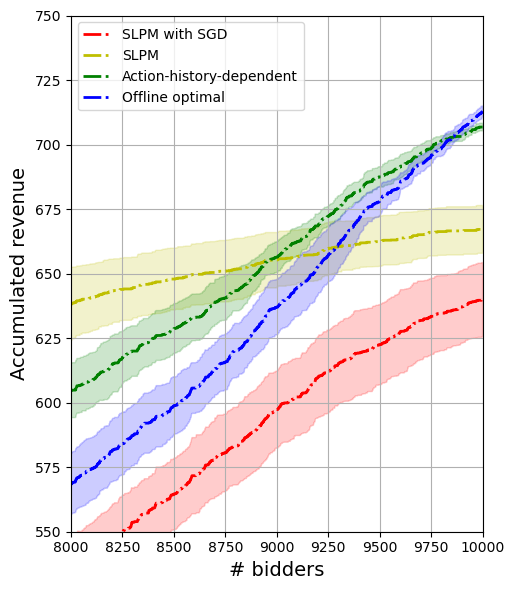

In [406]:
plot_ci_lines([SGD_path_list, SLPM_path_list, AHD_path_list, offline_path_list], 
              ['SLPM with SGD', 'SLPM', 'Action-history-dependent', 'Offline optimal'], 
              ['r', 'y', 'g', 'b'])

-73.05559727202805
-45.778173741400295
-6.135947694979893


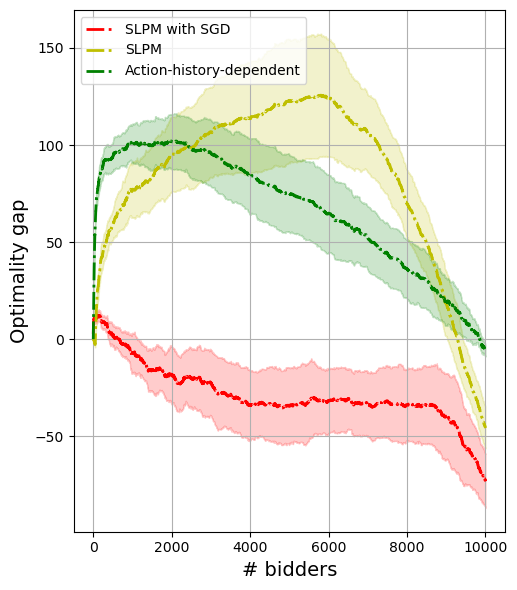

In [400]:
SLPM_path_diff_list = [SLPM_path_list[i] - offline_path_list[i] for i in range(10)]
SCPM_path_diff_list = [SCPM_path_list[i] - offline_path_list[i] for i in range(10)]
ADH_path_diff_list = [AHD_path_list[i] - offline_path_list[i] for i in range(10)]
SGD_path_diff_list = [SGD_path_list[i] - offline_path_list[i] for i in range(10)]
plot_ci_lines([SGD_path_diff_list, SLPM_path_diff_list, ADH_path_diff_list], 
              ['SLPM with SGD', 'SLPM', 'Action-history-dependent'], 
              ['r', 'y', 'g'])

## Online Price-Posting Market

In [4]:
def solve_fisher_SCPM(m, n, w, u, s):
    # Define the decision variables
    x = cp.Variable((m,n), nonneg=True)  # x_j variables
    r = cp.Variable(m, nonneg=True)  # x_j variables
    
    # Define the constraints
    constraints = [cp.sum(x[i,:n]) + r[i] <= s[i] for i in range(m)]

    # Define the utility function
    def utility_function(r, type='log'):
        if type == 'log':
            return (1/1) * cp.sum(cp.log(r))
        elif type == 'exp':
            return (1/1) * cp.sum(1 - cp.exp(-a_param * r))
        else:
            raise ValueError("Invalid utility function type")
    
    # Define the objective
    objective = cp.Maximize(cp.sum([w[j] * cp.log(cp.sum([u[i,j]*x[i,j] for i in range(m)])) for j in range(n)]) + utility_function(r))
    
    # Define the problem and solve it
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    return np.array([constraint.dual_value for constraint in constraints[:m]])

In [5]:
def solve_util(m, p, u_j, w_j):
    # Initialize the model
    model = Model('util')
    model.setParam('OutputFlag', 0)
    
    # Add variables xj for each bidder j
    x = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="x")
    
    # Set the objective function
    model.setObjective(sum(u_j[i] * x[i] for i in range(m)), GRB.MAXIMIZE)
    
    # Add constraint for the sum of probabilities
    constraint = model.addConstr(sum(p[i] * x[i] for i in range(m)) <= w_j, name="budget_constraint")
    
    # Solve the model
    model.optimize()
    
    # Check the model status and output the solution
    if model.status == GRB.OPTIMAL:
        optimal_value = model.objVal
        x_solution = model.getAttr('x', x)
        return [x_solution[i] for i in range(m)], optimal_value
    else:
        print("No optimal solution found or the problem is not a continuous LP.")
        return None, None

In [6]:
class fisher_SCPM_Agent(object):
    def __init__(self, m, n, s, u, w):
        self.m = m
        self.n = n
        self.s = s
        self.u = u
        self.w = w
        self.cost = np.zeros(len(self.s))
        self.cost_path = []
        self.util_path = []

    def update_prices(self, k):
        self.prices = solve_fisher_SCPM(self.m, k, self.w[:k], self.u, self.s*k/self.n)
        return self.prices
        
    def simulate_util(self, k, T):
        '''
        update dual price with first k arrivals;
        simulate revenues starting from time k to time T;
        '''
        tot_util = 0
        prices = self.update_prices(k)
        
        for j in range(k, T):
            alloc, util = solve_util(self.m, prices, self.u[:, j], self.w[j])
            if min(self.s - self.cost - alloc) >= 0:
                self.cost += alloc
                self.cost_path.append(copy.deepcopy(self.cost))
                tot_util += util
                self.util_path.append(util)
            else:
                self.util_path.append(0)
                self.cost_path.append(copy.deepcopy(self.cost))

        return tot_util

    def rolling_simulate_util(self, k_list):
        tot_util = 0
        for j in range(k_list[0]):
            self.util_path.append(0)
        for i in range(len(k_list) - 1):
            cur_util = self.simulate_util(k_list[i], k_list[i+1])
            tot_util += cur_util
        tot_util += self.simulate_util(k_list[-1], self.n)
        return tot_util

    def simulate_offline(self):
        tot_util = 0
        prices = self.update_prices(self.n)
        self.offline_util_path = []
        
        for j in range(self.n):
            alloc, util = solve_util(self.m, prices, self.u[:, j], self.w[j])
            if min(self.s - self.cost - alloc) >= 0:
                self.cost += alloc
                self.cost_path.append(copy.deepcopy(self.cost))
                tot_util += util
                self.offline_util_path.append(util)
            else:
                self.offline_util_path.append(0)
                self.cost_path.append(copy.deepcopy(self.cost))
        return self.offline_util_path

In [19]:
# Example values for demonstration; these should be replaced with actual values
m = 10  # Replace with actual m value
n = 1000  # Replace with actual n value
# u = np.random.binomial(1, 0.5, (m,n))  # Replace with actual u matrix
u = np.random.rand(m, n)
s = np.array([100] * m)  # total available quantity of each good/resource
w = np.array([10] * n)  # total available quantity of each good/resource

k_list = [50*2**i for i in range(5)]

In [20]:
fisher_agent = fisher_SCPM_Agent(m, n, s, u, w)
tot_util = fisher_agent.rolling_simulate_util(k_list)
tot_util

831.3020992449472

In [21]:
offline_fisher_agent = fisher_SCPM_Agent(m, n, s, u, w)
_ = offline_fisher_agent.simulate_offline()

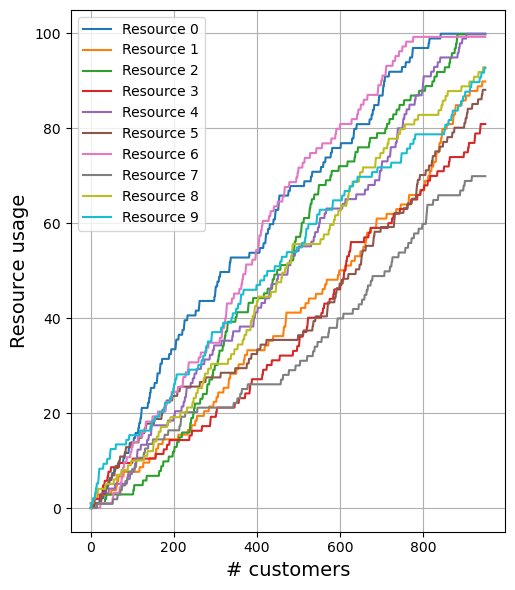

In [23]:
plt.figure(figsize=(7, 6))  # Set a figure size to make the plot larger.

cost_path = np.array(fisher_agent.cost_path)
for m_index in range(cost_path.shape[1]):
    plt.plot(cost_path[:, m_index], ls='-', label=f'Resource {m_index}')


plt.xlabel('# customers', fontsize=14)
plt.ylabel('Resource usage', fontsize=14)

plt.legend(loc=2)  # Place the legend outside the plot

plt.grid(True)  # Add a grid to the plot.
plt.grid(True)  # Add a grid to the plot
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust the padding of the plot, making room for the legend
plt.show()  # Display the plot.

In [11]:
np.random.seed(0)
m = 10  # Replace with actual m value
n = 1000  # Replace with actual n value
s = np.array([100] * m)  # total available quantity of each good/resource
w = np.array([10] * n)  # total available quantity of each good/resource

u_list = []
for i in range(10):
    u_list.append(np.random.rand(m, n))
    # u_list.append(np.random.binomial(1, 0.5, (m,n)))

In [12]:
fisher_SCPM_list = []
fisher_SCPM_cost_list = []
fisher_offline_list = []
fisher_offline_cost_list = []

for u in tqdm(u_list):
    fisher_agent = fisher_SCPM_Agent(m, n, s, u, w)
    tot_util = fisher_agent.rolling_simulate_util(k_list)
    fisher_SCPM_list.append(np.cumsum(fisher_agent.util_path))
    fisher_SCPM_cost_list.append(np.cumsum(fisher_agent.cost_path))
    offline_fisher_agent = fisher_SCPM_Agent(m, n, s, u, w)
    offline_path = np.cumsum(offline_fisher_agent.simulate_offline())
    fisher_offline_list.append(offline_path)
    fisher_offline_cost_list.append(np.cumsum(offline_fisher_agent.cost_path))

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
def plot_ci_lines(path_list, label_list, color_list):
    fig, ax = plt.subplots(figsize=(7, 6))  # Adjust the figure size for better visibility

    for i in range(len(path_list)):
        cur_path_list_T = np.transpose(np.array(path_list[i]))
        avg_cur_path_list_T = np.mean(cur_path_list_T, axis=1)
        print(avg_cur_path_list_T[-1])
        
        ax.plot(avg_cur_path_list_T, lw=2, linestyle='-.', color=color_list[i], label=label_list[i])
        
        ci = 1.96 * np.std(cur_path_list_T, axis=1)/np.sqrt(10)
        ax.fill_between(range(len(avg_cur_path_list_T)), (avg_cur_path_list_T - ci), (avg_cur_path_list_T + ci), 
                         color=color_list[i], alpha=0.2)

    ax.set_xlabel('# customers', fontsize=14)
    ax.set_ylabel('Accumulated welfare', fontsize=14)
    ax.legend(loc=2)  # Place the legend outside the plot
    plt.xlim((0, 1000))  # Set the limits for the x-axis
    plt.ylim((0, 1000))  # Set the limits for the y-axis
    
    plt.grid(True)  # Add a grid to the plot
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust the padding of the plot, making room for the legend

823.8111459657187
903.0373034611011


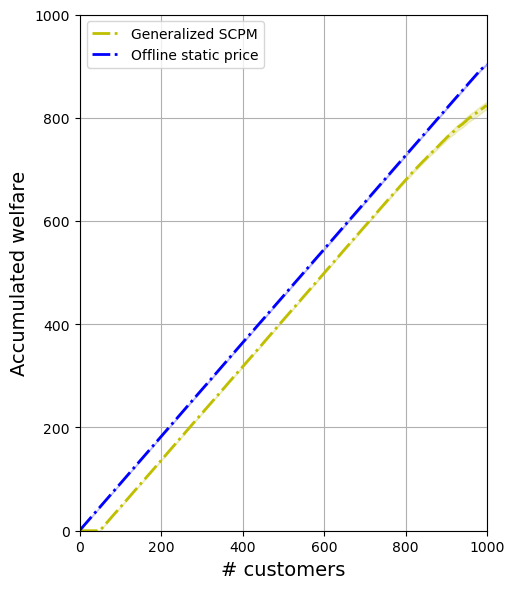

In [14]:
plot_ci_lines([fisher_SCPM_list, fisher_offline_list], 
              ['Generalized SCPM', 'Offline static price'], 
              ['y', 'b'])